In [10]:
import torch 
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import torch.utils.data
from torch.nn.utils import clip_grad_norm
train_data = torchvision.datasets.MNIST(
    root='./mnist', #保存位置
    train=True, #training set
    transform=torchvision.transforms.ToTensor(), #converts a PIL.Image to torch.FloatTensor(C*H*W) in range(0.0,1.0)
    download=True
)
test_data = torchvision.datasets.MNIST(
    root='./MNIST',
    train=False,
    transform=torchvision.transforms.ToTensor()
)

In [15]:
from math import ceil
'''adjust learning with epoch:0: {'optimizer': 'SGD', 'lr':  1e-1, 'weight_decay': 1e-4, 'momentum': 0.9},
                        epoch:10: {'lr': 1e-2},
                        epoch:20: {'lr':  1e-3},
                        epoch:30: {'lr':  1e-4}
'''
def adjust_learning_rate(optimizer, epoch):
    if epoch+1 == 10:
        for param_group in optimizer.param_groups:
            param_group['lr'] = 1e-2
    if epoch+1 == 20:
        for param_group in optimizer.param_groups:
            param_group['lr'] = 1e-3
    if epoch+1 == 30:
        for param_group in optimizer.param_groups:
            param_group['lr'] = 1e-4
        
        
# main function
def train(batchsize):
    torch.manual_seed(123) #reproducible

    EPOCH = 50
    BATCH_SIZE = batchsize
    train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE,shuffle=False)
    num_iters = EPOCH*len(train_loader)
    distance = np.zeros(EPOCH+1)

    # f1 model structure
    class mnist_model(nn.Module):

        def __init__(self):
            super(mnist_model, self).__init__()
            self.layers = nn.Sequential(
                nn.Linear(28 * 28, 512),
                nn.BatchNorm1d(512),
                nn.ReLU(True),
                nn.Linear(512, 512),
                nn.BatchNorm1d(512),
                nn.ReLU(True),
                nn.Linear(512, 512),
                nn.BatchNorm1d(512),
                nn.ReLU(True),
                nn.Linear(512, 512),
                nn.BatchNorm1d(512),
                nn.ReLU(True),
                nn.Linear(512, 512),
                nn.BatchNorm1d(512),
                nn.ReLU(True),
                nn.Linear(512, 10),
            )
        def forward(self, inputs):
            return self.layers(inputs.view(inputs.size(0), -1))
    #loss function and opimizer    
    model = mnist_model()
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-1,weight_decay= 1e-4, momentum=0.9)
    loss_func = nn.CrossEntropyLoss()
    init_weights = [w.data.cpu().clone() for w in list(model.parameters())]

    #train process
    for epoch in range(EPOCH):
    
        adjust_learning_rate(optimizer,epoch)
        #running_loss = 0.0
        for i, data in enumerate(train_loader,0):
           # get the inputs
            inputs, labels = data

            # wrap them in Variable
            inputs, labels = Variable(inputs), Variable(labels)

            # zero the parameter gradients
            model.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = loss_func(outputs, labels)
            loss.backward()
            clip_grad_norm(model.parameters(), 5.)     # clip grad avoding grad explosion
            optimizer.step()
        
            if i==0 and epoch==0: 
                step_dist = 0
                for k, w in enumerate(model.parameters()):  
                    #if k in idxs :    
                    step_dist +=  (w.data.cpu() - init_weights[k]).norm()
                              
                print('%d %d step_dist:%f'%(i+1,epoch+1,step_dist))
                distance[i] = step_dist
            if (i+1)%len(train_loader) ==0:
                step_dist = 0
                for k, w in enumerate(model.parameters()):  
                    #if k in idxs :    
                    step_dist +=  (w.data.cpu() - init_weights[k]).norm()
                              
                print('%d %d step_dist:%f'%(i+1,epoch+1,step_dist))
                distance[epoch+1] = step_dist
            
    print('Finished Training')
    np.save('dis%d.npy'%batchsize,distance)

In [16]:
import math
sqrt2 = math.sqrt(2)
#learning_rate = [1.0,1.0/sqrt2,0.5,0.5/sqrt2]
batchsize = [4096,2048,1024,512]

for i in range(0,len(batchsize)):
    train(batchsize[i])

1 1 step_dist:0.483708
15 1 step_dist:12.782729
15 2 step_dist:17.100357
15 3 step_dist:18.312388
15 4 step_dist:18.817015
15 5 step_dist:19.144106
15 6 step_dist:19.406088
15 7 step_dist:19.627860
15 8 step_dist:19.810170
15 9 step_dist:19.954158
15 10 step_dist:19.965395
15 11 step_dist:19.975170
15 12 step_dist:19.984431
15 13 step_dist:19.993604
15 14 step_dist:20.002545
15 15 step_dist:20.011586
15 16 step_dist:20.020413
15 17 step_dist:20.029171
15 18 step_dist:20.037950
15 19 step_dist:20.046777
15 20 step_dist:20.047632
15 21 step_dist:20.048485
15 22 step_dist:20.049343
15 23 step_dist:20.050195
15 24 step_dist:20.051047
15 25 step_dist:20.051893
15 26 step_dist:20.052745
15 27 step_dist:20.053594
15 28 step_dist:20.054439
15 29 step_dist:20.055294
15 30 step_dist:20.055376
15 31 step_dist:20.055459
15 32 step_dist:20.055541
15 33 step_dist:20.055623
15 34 step_dist:20.055705
15 35 step_dist:20.055788
15 36 step_dist:20.055869
15 37 step_dist:20.055950
15 38 step_dist:20.05603

D:\anaconda\lib\site-packages\matplotlib\__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


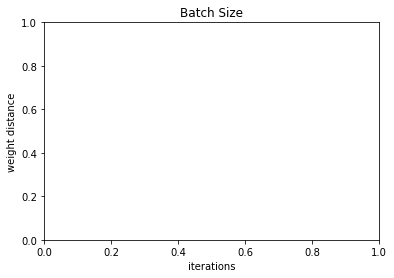

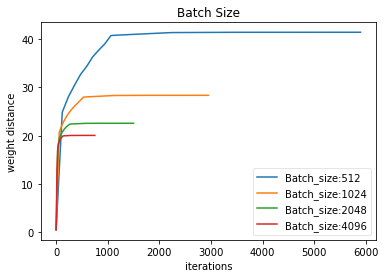

In [18]:
distance_lr_512 = np.load('dis512.npy')
distance_lr_1024 = np.load('dis1024.npy')
distance_lr_2048 = np.load('dis2048.npy')
distance_lr_4096 = np.load('dis4096.npy')
import matplotlib 
from matplotlib.ticker import  MultipleLocator
matplotlib.use('Agg')
BATCH_SIZE1 = 128

#x_index64=np.arange(0,70*938+1,938)
#x_index128=np.arange(0,70*469,70*469/66)
#x_index256=np.arange(0,70*235+1,235)
x_index512=np.arange(0,50*118+1,118)
x_index1024=np.arange(0,50*59+1,59)
x_index2048=np.arange(0,50*30+1,30)
x_index4096=np.arange(0,50*15+1,15)

fig = plt.figure()
plt.title("Batch Size")
plt.xlabel('iterations')
plt.ylabel('weight distance')
#plt.plot(x_index64,distance64,label='Batch_size:64')
#plt.plot(x_index128,distance128,label='Batch_size:128')
#plt.plot(x_index256,distance256,label='Batch_size:256')
plt.plot(x_index512,distance_lr_512,label='Batch_size:512')
plt.plot(x_index1024,distance_lr_1024,label='Batch_size:1024')
plt.plot(x_index2048,distance_lr_2048,label='Batch_size:2048')
plt.plot(x_index4096,distance_lr_4096,label='Batch_size:4096')
#plt.axis([-0.1,4,0.0,1.0]) 

#plt.fill_between(x_index,X1,X3,color = 'red',alpha = '0.1')
plt.legend(loc='lower right',framealpha = 0.5)
#plt.savefig("cSGD para.png") 
plt.show()

## adjust learning rate

In [22]:
from math import ceil
'''adjust learning with epoch:0: {'optimizer': 'SGD', 'lr':  1e-1, 'weight_decay': 1e-4, 'momentum': 0.9},
                        epoch:10: {'lr': 1e-2},
                        epoch:20: {'lr':  1e-3},
                        epoch:30: {'lr':  1e-4}
'''
def adjust_learning_rate(optimizer, epoch, batchsize):
    if epoch+1 == 10:
        for param_group in optimizer.param_groups:
            param_group['lr'] = 1e-2*(batchsize/128)**0.5
    if epoch+1 == 20:
        for param_group in optimizer.param_groups:
            param_group['lr'] = 1e-3*(batchsize/128)**0.5
    if epoch+1 == 30:
        for param_group in optimizer.param_groups:
            param_group['lr'] = 1e-4*(batchsize/128)**0.5
        
        
# main function
def trainlr(batchsize):
    torch.manual_seed(123) #reproducible

    EPOCH = 20
    BATCH_SIZE = batchsize
    train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE,shuffle=False)
    num_iters = EPOCH*len(train_loader)
    distance = np.zeros(EPOCH+1)

    # f1 model structure
    class mnist_model(nn.Module):

        def __init__(self):
            super(mnist_model, self).__init__()
            self.layers = nn.Sequential(
                nn.Linear(28 * 28, 512),
                nn.BatchNorm1d(512),
                nn.ReLU(True),
                nn.Linear(512, 512),
                nn.BatchNorm1d(512),
                nn.ReLU(True),
                nn.Linear(512, 512),
                nn.BatchNorm1d(512),
                nn.ReLU(True),
                nn.Linear(512, 512),
                nn.BatchNorm1d(512),
                nn.ReLU(True),
                nn.Linear(512, 512),
                nn.BatchNorm1d(512),
                nn.ReLU(True),
                nn.Linear(512, 10),
            )
        def forward(self, inputs):
            return self.layers(inputs.view(inputs.size(0), -1))
    #loss function and opimizer    
    model = mnist_model()
    optimizer = torch.optim.SGD(model.parameters(), lr=(1e-1)*(batchsize/128)**0.5,weight_decay= 1e-4, momentum=0.9)
    loss_func = nn.CrossEntropyLoss()
    init_weights = [w.data.cpu().clone() for w in list(model.parameters())]

    #train process
    for epoch in range(EPOCH):
    
        adjust_learning_rate(optimizer,epoch,batchsize)
        #running_loss = 0.0
        for i, data in enumerate(train_loader,0):
           # get the inputs
            inputs, labels = data

            # wrap them in Variable
            inputs, labels = Variable(inputs), Variable(labels)

            # zero the parameter gradients
            model.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = loss_func(outputs, labels)
            loss.backward()
            clip_grad_norm(model.parameters(), 5.)     # clip grad avoding grad explosion
            optimizer.step()
        
            if i==0 and epoch==0: 
                step_dist = 0
                for k, w in enumerate(model.parameters()):  
                    #if k in idxs :    
                    step_dist +=  (w.data.cpu() - init_weights[k]).norm()
                              
                print('%d %d step_dist:%f'%(i+1,epoch+1,step_dist))
                distance[i] = step_dist
            if (i+1)%len(train_loader) ==0:
                step_dist = 0
                for k, w in enumerate(model.parameters()):  
                    #if k in idxs :    
                    step_dist +=  (w.data.cpu() - init_weights[k]).norm()
                              
                print('%d %d step_dist:%f'%(i+1,epoch+1,step_dist))
                distance[epoch+1] = step_dist
            
    print('Finished Training')
    np.save('dislr%d.npy'%batchsize,distance)

In [23]:
import math

batchsize = [4096,2048]

for i in range(0,len(batchsize)):
    trainlr(batchsize[i])

1 1 step_dist:2.736266
15 1 step_dist:37.118243
15 2 step_dist:47.231146
15 3 step_dist:49.947116
15 4 step_dist:50.967750
15 5 step_dist:51.559133
15 6 step_dist:52.060128
15 7 step_dist:52.511129
15 8 step_dist:52.920034
15 9 step_dist:53.288506
15 10 step_dist:53.316763
15 11 step_dist:53.338304


KeyboardInterrupt: 

## ghost gbm

In [41]:
from math import ceil
'''adjust learning with epoch:0: {'optimizer': 'SGD', 'lr':  1e-1, 'weight_decay': 1e-4, 'momentum': 0.9},
                        epoch:10: {'lr': 1e-2},
                        epoch:20: {'lr':  1e-3},
                        epoch:30: {'lr':  1e-4}
'''
'''
def adjust_learning_rate(optimizer, epoch, batchsize):
    if epoch+1 == 10:
        for param_group in optimizer.param_groups:
            param_group['lr'] = 1e-2*(batchsize/128)**0.5
    if epoch+1 == 20:
        for param_group in optimizer.param_groups:
            param_group['lr'] = 1e-3*(batchsize/128)**0.5
    if epoch+1 == 30:
        for param_group in optimizer.param_groups:
            param_group['lr'] = 1e-4*(batchsize/128)**0.5
        
'''       
# main function
def traingbm(batchsize):
    torch.manual_seed(123) #reproducible

    EPOCH = 50
    BATCH_SIZE = batchsize
    train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE,shuffle=False)
    num_iters = EPOCH*len(train_loader)
    distance = np.zeros(EPOCH+1)

    # f1 model structure
    class mnist_model(nn.Module):

        def __init__(self):
            super(mnist_model, self).__init__()
            self.layers = nn.Sequential(
                nn.Linear(28 * 28, 512),
                nn.BatchNorm1d(512),
                nn.ReLU(True),
                nn.Linear(512, 512),
                nn.BatchNorm1d(512),
                nn.ReLU(True),
                nn.Linear(512, 512),
                nn.BatchNorm1d(512),
                nn.ReLU(True),
                nn.Linear(512, 512),
                nn.BatchNorm1d(512),
                nn.ReLU(True),
                nn.Linear(512, 512),
                nn.BatchNorm1d(512),
                nn.ReLU(True),
                nn.Linear(512, 10),
            )
        def forward(self, inputs):
            return self.layers(inputs.view(inputs.size(0), -1))
    #loss function and opimizer    
    model = mnist_model()
    optimizer = torch.optim.SGD(model.parameters(), lr=(1e-1)*(batchsize/64)**0.5,weight_decay= 1e-4, momentum=0.9)
    loss_func = nn.CrossEntropyLoss()
    init_weights = [w.data.cpu().clone() for w in list(model.parameters())]
    mini_batch_size = 64
    #train process
    for epoch in range(EPOCH):
    
        #adjust_learning_rate(optimizer,epoch, batchsize)
        #running_loss = 0.0
        for i, data in enumerate(train_loader,0):
           # get the inputs
            inputs, labels = data

            # wrap them in Variable
            inputs, labels = Variable(inputs), Variable(labels)
           # gbn
            mini_inputs = inputs.chunk(batchsize // mini_batch_size)
            mini_targets = labels.chunk(batchsize // mini_batch_size)


            optimizer.zero_grad()

            for k, mini_input_var in enumerate(mini_inputs):
                mini_target_var = mini_targets[k]
                output = model(mini_input_var)
                loss = loss_func(output, mini_target_var)

                # compute gradient and do SGD step
                loss.backward()

            for p in model.parameters():
                p.grad.data.div_(len(mini_inputs))
            clip_grad_norm(model.parameters(), 5.)     # clip grad avoding grad explosion
            
            optimizer.step()

            if i==0 and epoch==0: 
                step_dist = 0
                for k, w in enumerate(model.parameters()):  
                    #if k in idxs :    
                    step_dist +=  (w.data.cpu() - init_weights[k]).norm()
                              
                print('%d %d step_dist:%f'%(i+1,epoch+1,step_dist))
                distance[i] = step_dist
            if (i+1)%len(train_loader) ==0:
                step_dist = 0
                for k, w in enumerate(model.parameters()):  
                    #if k in idxs :    
                    step_dist +=  (w.data.cpu() - init_weights[k]).norm()
                              
                print('%d %d step_dist:%f'%(i+1,epoch+1,step_dist))
                distance[epoch+1] = step_dist
            
    print('Finished Training')
    np.save('gbn%d.npy'%batchsize,distance)

In [42]:
import math

batchsize = [2048,1024,512,256,128,64]

for i in range(0,len(batchsize)):
    traingbm(batchsize[i])

1 1 step_dist:2.750861
30 1 step_dist:50.363225
30 2 step_dist:55.977649
30 3 step_dist:58.218914
30 4 step_dist:60.013319
30 5 step_dist:61.785152
30 6 step_dist:63.538333
30 7 step_dist:65.237328
30 8 step_dist:66.942615
30 9 step_dist:68.594675
30 10 step_dist:70.252233
30 11 step_dist:71.888575
30 12 step_dist:73.206540
30 13 step_dist:74.583692
30 14 step_dist:76.053017
30 15 step_dist:77.608099
30 16 step_dist:79.003669
30 17 step_dist:80.163969
30 18 step_dist:81.385710
30 19 step_dist:82.611291
30 20 step_dist:83.666970
30 21 step_dist:84.739377
30 22 step_dist:85.729643
30 23 step_dist:86.859591
30 24 step_dist:87.838134
30 25 step_dist:88.944955
30 26 step_dist:89.933537
30 27 step_dist:91.318771
30 28 step_dist:92.440253
30 29 step_dist:93.186212
30 30 step_dist:93.974188
30 31 step_dist:94.850704
30 32 step_dist:95.625377
30 33 step_dist:96.229818
30 34 step_dist:97.170824
30 35 step_dist:98.001818
30 36 step_dist:98.564669
30 37 step_dist:99.218511
30 38 step_dist:100.0154

938 45 step_dist:158.768030
938 46 step_dist:158.645815
938 47 step_dist:158.733756
938 48 step_dist:158.770721
938 49 step_dist:158.747098
938 50 step_dist:158.962220
Finished Training


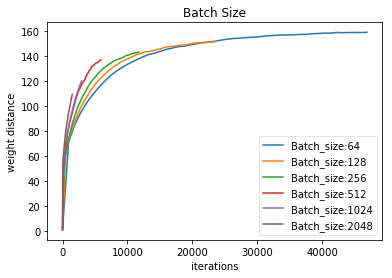

In [43]:
distance_lr_64 = np.load('gbn64.npy')
distance_lr_128 = np.load('gbn128.npy')
distance_lr_256 = np.load('gbn256.npy')
distance_lr_512 = np.load('gbn512.npy')
distance_lr_1024 = np.load('gbn1024.npy')
distance_lr_2048 = np.load('gbn2048.npy')
#distance_lr_4096 = np.load('dis4096.npy')
import matplotlib 
from matplotlib.ticker import  MultipleLocator
#matplotlib.use('Agg')
BATCH_SIZE1 = 128

x_index64=np.arange(0,50*938+1,938)
x_index128=np.arange(0,50*469+1,469)
x_index256=np.arange(0,50*235+1,235)
x_index512=np.arange(0,50*118+1,118)
x_index1024=np.arange(0,50*59+1,59)
x_index2048=np.arange(0,50*30+1,30)
#x_index4096=np.arange(0,50*15+1,15)

fig = plt.figure()
plt.title("Batch Size")
plt.xlabel('iterations')
plt.ylabel('weight distance')

plt.plot(x_index64,distance_lr_64,label='Batch_size:64')
plt.plot(x_index128,distance_lr_128,label='Batch_size:128')
plt.plot(x_index256,distance_lr_256,label='Batch_size:256')
plt.plot(x_index512,distance_lr_512,label='Batch_size:512')
plt.plot(x_index1024,distance_lr_1024,label='Batch_size:1024')
plt.plot(x_index2048,distance_lr_2048,label='Batch_size:2048')
#plt.plot(x_index4096,distance_lr_4096,label='Batch_size:4096')
#plt.axis([-0.1,4,0.0,1.0]) 

#plt.fill_between(x_index,X1,X3,color = 'red',alpha = '0.1')
plt.legend(loc='lower right',framealpha = 0.5)
plt.savefig("batchsize_gbn.jpg") 
plt.show()